In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Train Your Own Model and Serve It With TensorFlow Serving

In this notebook, you will train a neural network to classify images of handwritten digits from the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset. You will then save the trained model, and serve it using [TensorFlow Serving](https://www.tensorflow.org/tfx/guide/serving).

**Warning: This notebook is designed to be run in a Google Colab only**.  It installs packages on the system and requires root access. If you want to run it in a local Jupyter notebook, please proceed with caution.

## Setup

In [ ]:
try:
    %tensorflow_version 2.x
except:
    pass

In [ ]:
import os
import json
import tempfile
import requests
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

print("\u2022 Using TensorFlow Version:", tf.__version__)

• Using TensorFlow Version: 2.8.0


## Import the MNIST Dataset

The [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains 70,000 grayscale images of the digits 0 through 9. The images show individual digits at a low resolution (28 by 28 pixels). 

Even though these are really images, we will load them as NumPy arrays and not as binary image objects.

In [ ]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [ ]:
# EXERCISE: Scale the values of the arrays below to be between 0.0 and 1.0.
train_images = train_images / 255. # YOUR CODE HERE
test_images = test_images / 255.# YOUR CODE HERE

In the cell below use the `.reshape` method to resize the arrays to the following sizes:

```python
train_images.shape: (60000, 28, 28, 1)
test_images.shape: (10000, 28, 28, 1)
```

In [ ]:
# EXERCISE: Reshape the arrays below.
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1) # YOUR CODE HERE
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)# YOUR CODE HERE

In [ ]:
print('\ntrain_images.shape: {}, of {}'.format(train_images.shape, train_images.dtype))
print('test_images.shape: {}, of {}'.format(test_images.shape, test_images.dtype))


train_images.shape: (60000, 28, 28, 1), of float64
test_images.shape: (10000, 28, 28, 1), of float64


## Look at a Sample Image

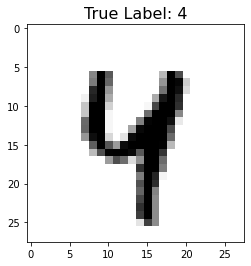

In [ ]:
idx = 42

plt.imshow(test_images[idx].reshape(28,28), cmap=plt.cm.binary)
plt.title('True Label: {}'.format(test_labels[idx]), fontdict={'size': 16})
plt.show()

## Build a Model

In the cell below build a `tf.keras.Sequential` model that can be used to classify the images of the MNIST dataset. Feel free to use the simplest possible CNN. Make sure your model has the correct `input_shape` and the correct number of output units.

In [ ]:
# EXERCISE: Create a model.
model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(input_shape=(28,28,1), filters=8, kernel_size=3,
                               strides=2, activation='relu', name='Conv1'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(10, activation=tf.nn.softmax, name='Softmax')
                             
                      


])# YOUR CODE HERE

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1 (Conv2D)              (None, 13, 13, 8)         80        
                                                                 
 flatten (Flatten)           (None, 1352)              0         
                                                                 
 Softmax (Dense)             (None, 10)                13530     
                                                                 
Total params: 13,610
Trainable params: 13,610
Non-trainable params: 0
_________________________________________________________________


## Train the Model

In the cell below configure your model for training using the `adam` optimizer, `sparse_categorical_crossentropy` as the loss, and `accuracy` for your metrics. Then train the model for the given number of epochs, using the `train_images` array.

In [ ]:
# EXERCISE: Configure the model for training.
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

epochs = 5

# EXERCISE: Train the model.
history = model.fit(train_images, train_labels, epochs=epochs, verbose=2)

Epoch 1/5
1875/1875 - 6s - loss: 0.3319 - accuracy: 0.9096 - 6s/epoch - 3ms/step
Epoch 2/5
1875/1875 - 5s - loss: 0.1407 - accuracy: 0.9600 - 5s/epoch - 3ms/step
Epoch 3/5
1875/1875 - 5s - loss: 0.1066 - accuracy: 0.9699 - 5s/epoch - 3ms/step
Epoch 4/5
1875/1875 - 4s - loss: 0.0889 - accuracy: 0.9746 - 4s/epoch - 2ms/step
Epoch 5/5
1875/1875 - 4s - loss: 0.0788 - accuracy: 0.9769 - 4s/epoch - 2ms/step


## Evaluate the Model

In [ ]:
# EXERCISE: Evaluate the model on the test images.
results_eval = model.evaluate(test_images, test_labels)# YOUR CODE HERE

for metric, value in zip(model.metrics_names, results_eval):
    print(metric + ': {:.3}'.format(value))

313/313 [==============================] - 1s 3ms/step - loss: 0.0794 - accuracy: 0.9756
loss: 0.0794
accuracy: 0.976


## Save the Model

In [ ]:
MODEL_DIR = tempfile.gettempdir()

version = 1

export_path = os.path.join(MODEL_DIR, str(version))

if os.path.isdir(export_path):
    print('\nAlready saved a model, cleaning up\n')
    !rm -r {export_path}

model.save(export_path, save_format="tf")

print('\nexport_path = {}'.format(export_path))
!ls -l {export_path}


Already saved a model, cleaning up



INFO:tensorflow:Assets written to: /tmp/1/assets


INFO:tensorflow:Assets written to: /tmp/1/assets



export_path = /tmp/1
total 88
drwxr-xr-x 2 root root  4096 Apr 26 13:51 assets
-rw-r--r-- 1 root root  8105 Apr 26 13:51 keras_metadata.pb
-rw-r--r-- 1 root root 73272 Apr 26 13:51 saved_model.pb
drwxr-xr-x 2 root root  4096 Apr 26 13:51 variables


## Examine Your Saved Model

In [ ]:
!saved_model_cli show --dir {export_path} --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['Conv1_input'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 28, 28, 1)
        name: serving_default_Conv1_input:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['Softmax'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 10)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict

Concrete Functions:
  Function Name: '__call__'
    Option #1
      Callable with:
        Argument #1
          Conv1_inp

## Add TensorFlow Serving Distribution URI as a Package Source

In [ ]:
# This is the same as you would do from your command line, but without the [arch=amd64], and no sudo
# You would instead do:
# echo "deb [arch=amd64] http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | sudo tee /etc/apt/sources.list.d/tensorflow-serving.list && \
# curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | sudo apt-key add -

!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | apt-key add -
!apt update

deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0   4271      0 --:--:-- --:--:-- --:--:--  4265
OK
Hit:1 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:4 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:5 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:6 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:7 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:9 https://developer.download.nvidia.com/compute/cuda/repos/u

## Install TensorFlow Serving

In [ ]:
!apt-get install tensorflow-model-server

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tensorflow-model-server is already the newest version (2.8.0).
0 upgraded, 0 newly installed, 0 to remove and 59 not upgraded.


## Run the TensorFlow Model Server

You will now launch the TensorFlow model server with a bash script. In the cell below use the following parameters when running the TensorFlow model server:

* `rest_api_port`: Use port `8501` for your requests.


* `model_name`: Use `digits_model` as your model name. 


* `model_base_path`: Use the environment variable `MODEL_DIR` defined below as the base path to the saved model.

In [ ]:
os.environ["MODEL_DIR"] = MODEL_DIR

In [ ]:
# EXERCISE: Fill in the missing code below.
%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name=digits_model \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1

Starting job # 0 in a separate thread.


In [ ]:
!tail server.log

## Create JSON Object with Test Images

In the cell below construct a JSON object and use the first three images of the testing set (`test_images`) as your data.

In [ ]:
# EXERCISE: Create JSON Object
data = json.dumps({"signature_name": "serving_default", "instances": test_images[0:3].tolist()})# YOUR CODE HERE

## Make Inference Request

In the cell below, send a predict request as a POST to the server's REST endpoint, and pass it your test data. You should ask the server to give you the latest version of your model.

In [ ]:
# EXERCISE: Fill in the code below
headers = {"content-type": "application/json"}
json_response = requests.post('http://192.168.1.1:8501/v1/models/digits_model:predict', data=data, headers=headers)
    
predictions = json.loads(json_response.text)['predictions']

## Plot Predictions

In [ ]:
plt.figure(figsize=(10,15))

for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(test_images[i].reshape(28,28), cmap = plt.cm.binary)
    plt.axis('off')
    color = 'green' if np.argmax(predictions[i]) == test_labels[i] else 'red'
    plt.title('Prediction: {}\nTrue Label: {}'.format(np.argmax(predictions[i]), test_labels[i]), color=color)
    
plt.show()